In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("../../../data/santander-customer-satisfaction/train.csv", encoding='latin-1')
predict_df = pd.read_csv("../../../data/santander-customer-satisfaction/test.csv", encoding='latin-1')
santander_submission_df = pd.read_csv("../../../data/santander-customer-satisfaction/sample_submission.csv", encoding='latin-1')

print(cust_df['TARGET'].value_counts())

total_cnt = cust_df.TARGET.count()
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt * 100)))

print('santander customer satisfaction: 데이터 세트 Null 값 갯수 ',cust_df.isnull().sum().sum())

cust_df.drop('ID', axis=1, inplace=True) # 필요 없는 행 삭제

X = cust_df.iloc[:, :-1]
y = cust_df.iloc[:, -1]

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 3.96
santander customer satisfaction: 데이터 세트 Null 값 갯수  0


In [3]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(
    n_estimators=50, 
    max_samples=50, 
    contamination=float(0.004), 
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0
)

# 모델 학습
clf.fit(X)
pred = clf.predict(X)


# 예측 결과를 데이터프레임에 추가
X['anomaly'] = pred


# 이상치 데이터 추출 / 1=정상, -1=이상치
outliers = X.loc[X['anomaly'] == -1]
outlier_index = list(outliers.index)


# 이상치와 정상치 개수 출력
print(X['anomaly'].value_counts()) 


# 이상치를 제외한 데이터 추출
X = X.loc[X['anomaly'] != -1]
X = X.drop(columns=['anomaly'])  # 'anomaly' 열 제거


# y에서도 이상치 인덱스 제거
y = y.drop(outlier_index)

predict_df.drop('ID', axis=1, inplace=True)

anomaly
 1    75715
-1      305
Name: count, dtype: int64


In [4]:
print('피처 데이터 shape:{0}'.format(X.shape))
print('피처 데이터 shape:{0}'.format(y.shape))
print('santander customer satisfaction: 데이터 세트 Null 값 갯수 ', X.isnull().sum().sum())

# 표준화 => 2차원 데이터
# sc = StandardScaler()
# X = sc.fit_transform(X)
# print('피처 데이터 shape:{0}'.format(X.shape))

# predict_df = sc.transform(predict_df)
# print('피처 데이터 shape:{0}'.format(predict_df.shape))

피처 데이터 shape:(75715, 369)
피처 데이터 shape:(75715,)
santander customer satisfaction: 데이터 세트 Null 값 갯수  0


In [7]:
# pred_pd = clf.predict(predict_df)

# # 예측 결과를 데이터프레임에 추가
# predict_df['anomaly'] = pred_pd

# # 이상치를 제외한 데이터 추출
# predict_df = predict_df.loc[predict_df['anomaly'] != -1]
# predict_df = predict_df.drop(columns=['anomaly'])  # 'anomaly' 열 제거

# predict_df = sc.transform(predict_df)
# print('피처 데이터 shape:{0}'.format(predict_df.shape))

In [6]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_3, y_3 = smoteto.fit_resample(X, y)

print('피처 데이터 shape:{0}'.format(X_3.shape))
print('피처 데이터 shape:{0}'.format(predict_df.shape))

피처 데이터 shape:(143583, 369)
피처 데이터 shape:(75818, 369)


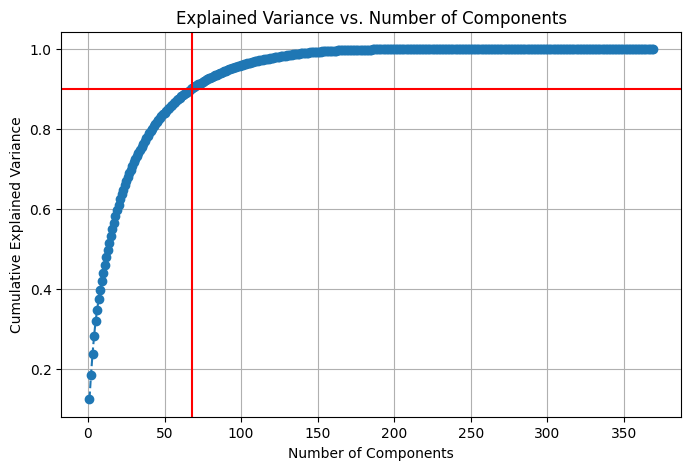

Optimal number of components for 90% variance: 68


In [100]:
from sklearn.decomposition import PCA

# PCA를 실행하여 설명된 분산 비율을 구하기
pca = PCA()
pca1 = pca.fit(X_3)
explained_variance_ratio = pca.explained_variance_ratio_

# 누적 설명된 분산 비율을 구하기
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 누적 설명된 분산 비율이 90% 이상이 되는 지점을 찾기
threshold = 0.90
optimal_n_components = np.argmax(cumulative_explained_variance >= threshold) + 1

# 설명된 분산 비율을 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')
plt.axvline(x=optimal_n_components, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

print(f"Optimal number of components for 90% variance: {optimal_n_components}")

# 설명된 분산 비율이 90% 또는 95% 이상을 차지하는 지점에서의 n_components 값을 선택할 수 있다.
# 일반적으로 누적 설명된 분산 비율이 90% 이상이 되는 지점을 선택하는 것이 좋다.
# 설명된 분산 비율이 급격히 증가하다가 점차 완만해지는 "엘보(elbow)" 지점을 찾는 것이 중요

In [101]:
pca = PCA(n_components=optimal_n_components)
X_3 = pca.fit_transform(X_3)
predict_df = pca.transform(predict_df)

# X_train, X_test, y_train, y_test = train_test_split(pca_test, y_3, test_size=0.2, random_state=0)
# train_cnt = y_train.count()
# test_cnt = y_test.count()
# print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape), '\n')

# print('학습 세트 레이블 값 분포 비율')
# print(y_train.value_counts()/train_cnt * 100)

# print('\n 테스트 세트 레이블 값 분포 비율')
# print(y_test.value_counts()/test_cnt * 100, '\n')

In [8]:
# min-max 스케일링을 사용해 0~1 사이의 값으로 변환
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_3 = scaler.fit_transform(X_3)
predict_df = scaler.transform(predict_df)

X_3

array([[0.99976406, 0.18      , 0.        , ..., 0.        , 0.        ,
        0.00154526],
       [0.99976406, 0.29      , 0.        , ..., 0.        , 0.        ,
        0.0020025 ],
       [0.99976406, 0.18      , 0.        , ..., 0.        , 0.        ,
        0.00282212],
       ...,
       [0.99976406, 0.23      , 0.        , ..., 0.        , 0.        ,
        0.00256269],
       [0.99976406, 0.36      , 0.        , ..., 0.        , 0.        ,
        0.00530331],
       [0.99976406, 0.31      , 0.        , ..., 0.        , 0.        ,
        0.00185337]])

In [9]:
# EF-SVM
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.svm import SVC

select_k_best_chi2 = SelectKBest(chi2, k=70)
# 카이제곱(chi-squared) 통계량을 사용하여 상위 20개의 피처를 선택
# 카이제곱 검정은 주로 범주형 데이터에 대해 사용되며, 각 피처와 타깃 변수 간의 독립성을 평가

select_k_best_mi = SelectKBest(mutual_info_classif, k=70)
# 상호 정보(mutual information)를 사용하여 상위 20개의 피처를 선택
# 상호 정보는 각 피처와 타깃 변수 간의 상관성을 평가


# 두 가지 피처 선택 방법을 사용하여 실제로 피처 선택을 수행
X_new_chi2 = select_k_best_chi2.fit_transform(X_3, y_3)
X_new_mi = select_k_best_mi.fit_transform(X_3, y_3)


# 피처 선택 객체로 predict_df 변환
predict_df_chi2 = select_k_best_chi2.transform(predict_df)
predict_df_mi = select_k_best_mi.transform(predict_df)


# 결합
# X_new_chi2와 X_new_mi를 수평으로 쌓아(concatenate) 새로운 데이터 X_new_combined를 만든다.
# 각 피처 선택 방법에 의해 선택된 피처들을 모두 포함한 새로운 데이터 세트를 생성
X_new_combined = np.hstack((X_new_chi2, X_new_mi))
predict_df_combined = np.hstack((predict_df_chi2, predict_df_mi))

X_new_combined.shape

(143583, 140)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_new_combined, y_3, test_size=0.2, random_state=42)

svc = SVC(kernel='linear', C=1, random_state=42)
svc.fit(X_train, y_train)

# 모델 평가
y_pred = svc.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"SVM 정확도: {accuracy * 100:.2f}%")

# 교차 검증을 통한 평가
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(svc, X_train, y_train, cv=5)
print(f"Cross-validation 평균 정확도: {np.mean(cross_val_scores) * 100:.2f}%")

SVM 정확도: 80.33%
Cross-validation 평균 정확도: 80.25%


In [12]:
svc_pred = svc.predict(X_test)

print('svm 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, svc_pred)))
print(f"train score: {svc.score(X_train, y_train)}")

svm 분류기 정확도: 0.8033
train score: 0.8033534727421517


In [11]:
predict_santander_pred_svm = svc.predict(predict_df_combined)
santander_submission_df['TARGET'] = predict_santander_pred_svm
santander_submission_df.to_csv('santander_submission_pca_svm.csv', index=False)
santander_submission_df

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,1
4,9,0
...,...,...
75813,151831,1
75814,151832,0
75815,151833,0
75816,151834,0
